## Import libraries

In [27]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pickle
import time
import os
import json

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Data
<br>CICIDS2017 dataset contains benign and the most up-to-date common attacks, which resembles the true real-world data (PCAPs). It also includes the results of the network traffic analysis using CICFlowMeter with labeled flows based on the time stamp, source, and destination IPs, source and destination ports, protocols and attack (CSV files). Also available is the extracted features definition.
<br>The data capturing period started at 9 a.m., Monday, July 3, 2017, and ended at 5 p.m. on Friday, July 7, 2017, for a total of 5 days. Monday is the normal day and only includes benign traffic. The implemented attacks include Brute Force FTP, Brute Force SSH, DoS, Heartbleed, Web Attack, Infiltration, Botnet and DDoS. They have been executed both morning and afternoon on Tuesday, Wednesday, Thursday and Friday.
<br> On this assignment, raw data (all CSV files concatinated to one pandas DataFrame) is located in: data/raw_data.pkl.

In [28]:
path2data = './data/raw_data.pkl'                                    # path to Data
start = time.time()                                                  # start loading time
with open(path2data, 'rb') as f:                                     # load data
    df = pickle.load(f)
end = time.time()                                                    # end loading time
print(f"Raw data loading time: {np.round(end - start, 2)} seconds")  # document loading time
memory_usage_GB = df.memory_usage(index=True).sum() * 1e-9           # memory usage
print(f"DataFrame occupies: {np.round(memory_usage_GB, 2)} GB")      # document memory usage

# Removes leading and trailing characters (whitespace)
# meaning was taken under consideration
df.columns = [col.strip() for col in list(df.columns)]
print(f"\nColumns Names (after striping):\n{df.columns}")

df = df.reset_index(drop=True)
print(f"Raw data shape: {df.shape}")                                 # raw data shape

Raw data loading time: 1.73 seconds
DataFrame occupies: 1.83 GB

Columns Names (after striping):
Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length M

## Data Preprocessing (Exploration and Wrangling)
<br>Describe:
<br>Generate descriptive statistics. Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values. Descriptive statistics is documented at: wrangling/descriptive_statistics.csv.

In [29]:
statistics = df.describe()                                    # descriptive statistics
statistics.T.to_csv('wrangling/descriptive_statistics.csv')   # save descriptive statistics as csv

<br>Observation: Flow Bytes/s and Flow Packets/s include numpy inf.
<br>Note: pandas isna() detects NA, Characters such as empty strings or numpy.inf are not considered NA values.
<br>numpy inf values will be replaced with the value of: 10 * feature_max_value

In [30]:
# columns with numpy -inf or inf
print(f"positive numpy inf in data: {df.columns[(df == np.inf).any()]}")
print(f"negative numpy inf in data: {df.columns[(df == -np.inf).any()]}")

positive numpy inf in data: Index(['Flow Bytes/s', 'Flow Packets/s'], dtype='object')
negative numpy inf in data: Index([], dtype='object')


What Labels include numpy inf? 

In [31]:
df['Label'][df['Flow Bytes/s'] == np.inf].value_counts()

BENIGN         1368
PortScan        126
Bot              10
FTP-Patator       3
DDoS              2
Name: Label, dtype: int64

In [32]:
df['Label'][df['Flow Packets/s'] == np.inf].value_counts()

BENIGN         1777
DoS Hulk        949
PortScan        126
Bot              10
FTP-Patator       3
DDoS              2
Name: Label, dtype: int64

In [33]:
df['Label'].loc[(df['Flow Packets/s'] == np.inf) & (df['Flow Bytes/s'] == np.inf)].value_counts()

BENIGN         1368
PortScan        126
Bot              10
FTP-Patator       3
DDoS              2
Name: Label, dtype: int64

In [34]:
# replace inf with nan temporarily for max value calculations
tmp = df[['Flow Bytes/s', 'Flow Packets/s']]
tmp = tmp.replace([-np.inf, np.inf], np.nan)
print(f"positive numpy inf in tmp: {tmp.columns[(tmp == np.inf).any()]}")
print(f"negative numpy inf in tmp: {tmp.columns[(tmp == -np.inf).any()]}")
max_dict = tmp.max().to_dict()

positive numpy inf in tmp: Index([], dtype='object')
negative numpy inf in tmp: Index([], dtype='object')


In [35]:
# replace inf with 10 * df['Flow Bytes/s'].max()
df['Flow Bytes/s'] = df['Flow Bytes/s'].replace(np.inf, 10 * max_dict['Flow Bytes/s'])     
# replace inf with 10 * df['Flow Packets/s'].max()
df['Flow Packets/s'] = df['Flow Packets/s'].replace(np.inf, 10 * max_dict['Flow Packets/s']) 

# check again for np.inf or -np.inf in data
print('post numpy inf replacement:')
print(f"positive numpy inf in data: {(df == np.inf).any().any()}")
print(f"negative numpy inf in data: {(df == -np.inf).any().any()}")

# check for NA values in data
print('NA values are in:')
print(df.columns[df.isna().any()])

post numpy inf replacement:
positive numpy inf in data: False
negative numpy inf in data: False
NA values are in:
Index(['Flow Bytes/s'], dtype='object')


What Labels include NA? 

In [36]:
df['Label'][df['Flow Bytes/s'].isna()].value_counts()

DoS Hulk    949
BENIGN      409
Name: Label, dtype: int64

<br>Observation: data includes NA values at 'Flow Bytes/s'
<br>Solution: replace missing data with modes. Modes values will be documented at utils/modes.json
<br>Note: NA values can be dropped, I chose not to because on this stage, I don't know the meaning of the action.

In [37]:
modes =  df.mode().T.to_dict()[0]  # get modes
del modes['Label']                 # delete Label
del modes['source']                # delete source

# save modes 
with open('utils/modes.json', 'w') as f:
    json.dump(json.dumps(modes), f)
    
# fill missing data
for col in list(df.columns):
    if df[col].isna().any():
        df[col] = df[col].fillna(modes[col])
        print(f"NaNs were found in {col} and replaced by the value {modes[col]}")
print(f"Missing data (after fillna): {df.isna().any().any()}")  

NaNs were found in Flow Bytes/s and replaced by the value 0.0
Missing data (after fillna): False


More exploration: data types and number of unique values in each feature

In [38]:
df.dtypes.to_csv('wrangling/raw_data_type.csv')          # data types
df.nunique().to_csv('wrangling/raw_data_n_uniques.csv')  # number of unique values

Observation: some of the features include only one unique value -> No contribution.
<br>Those features will be dropped 

In [39]:
nuniques = df.nunique()
df = df.drop(nuniques[nuniques == 1].index.to_list(), axis=1).reset_index(drop=True)
print(f"Data new shape (after dropping one value features): {df.shape}")

Data new shape (after dropping one value features): (2830743, 72)


Correlation between different features
<br>Dropping correlated features from data isn't always mandatory, but it's generally recommended for several reasons:
- Redundancy: Correlated features contain overlapping information. Keeping both provides no additional insights and can even be detrimental.
- Multicollinearity: Highly correlated features can lead to multicollinearity, where model coefficients become unreliable and interpretation difficult.
- Model Simplicity: Fewer features often lead to simpler models that are easier to interpret and potentially less prone to overfitting (memorizing the training data instead of learning general patterns).
- Computational Efficiency: Training models with fewer features can be faster, especially for complex algorithms.

<br> Correlation threshold chosen: 0.9
<br> Correlation matrix is documented in wrangling/raw_data_correlation.csv
<br> Correlated features names is documented in: utils/correlated_features_names.pkl

In [40]:
# Correlation between features
corr_matrix = df.corr().abs().round(2)
corr_matrix.to_csv('wrangling/raw_data_correlation.csv')

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
if len(to_drop) == 0:
    print('No significant correlation was found between features')
else:
    print(f"correlation was found at: {to_drop}")
    
with open('utils/correlated_features_names.pkl', 'wb') as f:
    pickle.dump(to_drop, f)
    
print(f"By using correlation threshold of {threshold}, {len(to_drop)} features were detected and will be dropped from data.")

correlation was found at: ['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']
By using correlation threshold of 0.9, 29 features were detected and will be dropped from data.


Note:
<br>There are situations where dropping correlated features might not be crucial:
- Domain Knowledge: If you have strong domain knowledge and understand the meaning of both features, keeping them might be beneficial.
- Ensemble Methods: Some ensemble methods (like Random Forests) can handle correlated features better.
- Feature Importance: If a correlated feature still has independent predictive power, it might be worth keeping.

In [41]:
# drop correlated features
df = df.drop(to_drop, axis=1).reset_index(drop=True)
print(f"New data shape (after dropping correlated features): {df.shape}")

New data shape (after dropping correlated features): (2830743, 43)


Drop Duplications
<br> Duplicate data points in K-Means (ML in general) can unfairly influence cluster centers, giving more weight to redundant information and potentially drowning out unique data points.

In [42]:
list2consider = list(set(list(df.columns)) - set(['source']))
df = df.drop_duplicates(subset = list2consider)
print(f"New data shape (after drop_duplicates): {df.shape}")

New data shape (after drop_duplicates): (2522256, 43)


Ouliers Suspects using IQR method
<br>IQR stands for Interquartile Range. It's a measure of spread or variability used in statistics, specifically focusing on the middle 50% of your data set. IQR is a valuable tool for understanding the distribution of your data, especially when outliers might be present.
<br> The data is composed of benign traffic (Monday) and attacks occured during the next 4 days. Seemingly, reducing ouliers at benign samples will reduce data overlapping with the attacks. There are issues with that statment, and the process should be done very carfully but for the purpose of this assignment, IQR method will be presented to identify noisy features. Those features will NOT be dropped. 
<br> IQR analysis results is documented in: wrangling/raw_data_IQR_analysis.csv

In [43]:
benign_data = df.loc[df['Label'] == 'BENIGN']
print(f"Number of samples in benign_data {benign_data.shape}")
print(f"Days distribution in benign_data:")
print(benign_data['source'].value_counts())

Number of samples in benign_data (2096378, 43)
Days distribution in benign_data:
Monday-WorkingHours.pcap_ISCX                              502752
Tuesday-WorkingHours.pcap_ISCX                             401009
Wednesday-workingHours.pcap_ISCX                           396988
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX    245983
Friday-WorkingHours-Morning.pcap_ISCX                      178240
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX         154540
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX           121770
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX                95096
Name: source, dtype: int64


Observation: most of the data composed out of BENIGN and distributed along all data sources (5 days)

In [44]:
iqr_analysis = []
iqr_analysis_columns = ['column', 'iqr', 'lower', 'upper', 'n_lower_outliers', 'n_upper_outliers']
whisker_width = 1.5
for col in list(benign_data.columns):
    if col in ['Label', 'source']:
        continue
    tmp = benign_data[col].describe()
    iqr = tmp.loc['75%'] - tmp.loc['25%']
    lower_ = tmp.loc['25%'] - whisker_width * iqr
    upper_ = tmp.loc['75%'] + whisker_width * iqr
    iqr_analysis.append([col, iqr, lower_,  upper_, len(df[col].loc[df[col] < lower_]), len(df[col].loc[df[col] > upper_].to_list())])
         
pd.DataFrame(iqr_analysis, columns=iqr_analysis_columns).to_csv('wrangling/raw_data_IQR_analysis.csv')

Conclusion: most of the features include more 100k outliers. A new way will be considered.

Downsizing integer

In [45]:
# for col in df.columns:
#     if col in ['Label', 'source']:
#         continue
#     before = df[col].dtypes
#     # Convert to numeric (might downgrade if possible)
#     if before == np.int64:
#         df[col] = df[col].astype(np.int16)
#     else:
#         df[col] = df[col].astype(np.float16)
#     after = df[col].dtypes
#     # Check the new data type
#     print(f"{col}: Before {before} After {after}") 

# memory_usage_GB = df.memory_usage(index=True).sum() * 1e-9           # memory usage
# print(f"DataFrame occupies: {np.round(memory_usage_GB, 2)} GB")      # document memory usage

## Clustering using K-Means - Unsupervised
<br> The goal is to idetify benign samples overlapped with attacks by clustering

In [46]:
# seperate Label and source from data
label_source = df[['Label', 'source']].reset_index(drop=True)
df = df.drop(['Label', 'source'], axis=1).reset_index(drop=True)
print(f"Features shape: {df.shape}. Label/source shape: {label_source.shape}")

Features shape: (2522256, 41). Label/source shape: (2522256, 2)


Standard Scaling
<br> K-means clustering relies on distance calculations to group data points. When features have different scales, features with larger scales dominate the distance calculation, even if they might not be as relevant for grouping. Scaling features ensures all features contribute equally based on their relative values, not just their magnitude, leading to more meaningful clusters.
<br>
<br>StandardScaler
<br>Standardize features by removing the mean and scaling to unit variance.
<br>The standard score of a sample x is calculated as:
<br>z = (x - u) / s
<br>where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or <br>one if with_std=False.

In [47]:
scaler = StandardScaler()
scaler.fit(df.values)
df_scaled = scaler.transform(df.values)

Elbow method
<br>The elbow method is a visual technique used to determine the optimal number of clusters (k) for K-means clustering. 

Now processing with K = 1
Now processing with K = 2
Now processing with K = 3
Now processing with K = 4
Now processing with K = 5
Now processing with K = 6
Now processing with K = 7
Now processing with K = 8
Now processing with K = 9
Now processing with K = 10
Now processing with K = 11
Now processing with K = 12
Now processing with K = 13
Now processing with K = 14


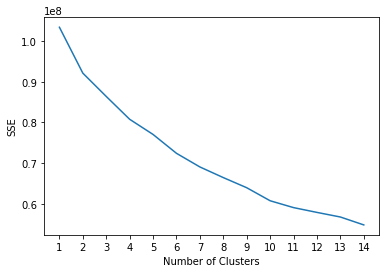

In [48]:
# initialize kmeans parameters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1,
}

#create list to hold SSE values for each k
sse = []
Ks = 15
for k in range(1, Ks):
    print(f"Now processing with K = {k}")
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

# visualize results
plt.figure()
plt.plot(range(1, Ks), sse)
plt.xticks(range(1, Ks))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig('Images/Elbow_Method.png')
plt.show()

Conclusion: Elbow method showed that K = 9 is a reasonable choice.

In [49]:
kmeans = KMeans(n_clusters=9, **kmeans_kwargs)
kmeans.fit(df_scaled)
label_source['cluster'] = kmeans.predict(df_scaled) # add cluster column to Label

In [50]:
# clusters distribution in benign samples
benigns = label_source[label_source['Label'] == 'BENIGN']
print(f"Precentage:")
print(benigns['cluster'].value_counts() / benigns.shape[0])

Precentage:
8    0.423977
6    0.255629
4    0.126328
0    0.106280
7    0.047635
3    0.014142
1    0.013407
2    0.010583
5    0.002017
Name: cluster, dtype: float64


Conclusion: ~96% of the data belong to clusters: 8, 6, 4, 0, 7
<br> The other 3% belong to clusters: 1, 2, 3, 5
<br> All samples belong to clusters  1, 2, 3, 5 will be discarded.
<br> Importent NOTE: those samples most be reported on and discussed with Sleek Data teams.

# Final data for ML model 
<br> Data for ML model will be saved at: data/processed_data.pkl

In [52]:
df = pd.concat([df, label_source], axis=1)
df = df[df['cluster'].isin([8, 6, 4, 0, 7])]
df = df.drop(['source', 'cluster'], axis=1)
df = df.reset_index(drop=True)
print(f"Data Final Shape: {df.shape}")
with open('data/processed_data.pkl', 'wb') as f:
    pickle.dump(df, f)

Data Final Shape: (2386579, 43)
